In [1]:
import torch
from fomoh.hyperdual import HyperTensor as htorch
from fomoh.nn import DenseModel, nll_loss
from fomoh.nn_models_torch import DenseModel_Torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

* The next cell is just to import MNIST and set up the data loaders

In [2]:
# Import necessary libraries
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Define transformations - MNIST images are in PIL format and need to be converted to tensors. 
# Also, it's common to normalize the MNIST dataset with a mean and std of 0.1307 and 0.3081 respectively.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

# Create DataLoader instances
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Compare PyTorch with Fomoh Model
* Here we compare the outputs of a Fomoh model (dense net) with a PyTorch one.
* We ensure both models are set with the same weights
* We then compare the loss, the directional derivative, and the second order quadratic term and show they match

In [3]:
device = "cpu"

hmodel = DenseModel(layers = [784,100,10])
tmodel = DenseModel_Torch(layers=[784,100,10])

# map torch weights to fomoh model weights:
hmodel.nn_module_to_htorch_model(tmodel)
hmodel.to(device)

# Check both models are the same:

# torch pred

# Zero out grads just in case:
for p in tmodel.parameters():
    p.grad = None

crit = torch.nn.CrossEntropyLoss()
tdata = torch.randn(10,784)
tlabels = torch.randint(0,10,(10,))
tpred = tmodel(tdata)
tloss = crit(tpred, tlabels)
tloss.backward(create_graph=True) # This might raise a warning but don't worry

# fomoh pred
loss_module = lambda x, y: nll_loss(x.logsoftmax(-1), y)
v_flat = torch.randn(hmodel.n_params)
v = hmodel.vec_to_params(v_flat) # define tangent vector and reshape to params list
hdata = htorch(tdata)
hlabels = htorch(tlabels)
hpred = hmodel(hdata, v)
hloss = loss_module(hpred, hlabels)

print("Predictions match: ", torch.allclose(hpred.real, tpred, rtol = 1e-7, atol = 1e-7))
print("Losses match: ", torch.allclose(hloss.real, tloss, rtol = 1e-7, atol = 1e-7))

# Collect torch grads: (using in-build Model function)
grads_p_shape = hmodel.collect_nn_module_grads(tmodel)
# Convert to flat vector
grads = hmodel.params_to_vec(grads_p_shape)
print("Directional derivatives match: ", torch.allclose(hloss.eps1, grads @ v_flat, rtol = 1e-5, atol = 1e-5))

# Use Hessian vector product to check second order matches:
reshape = lambda x : [v_.t() if len(v_.shape) == 2 else v_ for v_ in x] # function to transpose the correct weights
Hv = torch.autograd.grad(reshape(grads_p_shape), tmodel.parameters(), grad_outputs=reshape(v), only_inputs=True)
vTHv = sum((v_.flatten().dot(hv.flatten().detach()) for v_, hv in zip(reshape(v), Hv)))

print("Quadratic terms match (v^T H v): ", torch.allclose(hloss.eps1eps2, vTHv, rtol = 1e-5, atol = 1e-5))

Weights transferred to htorch model.
Predictions match:  True
Losses match:  True
Directional derivatives match:  True
Quadratic terms match (v^T H v):  True


/Users/adamcobb/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1000.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


### Simple Training loop with FoMoH-KD

In [4]:
from tqdm import tqdm
from fomoh.opt import optimizer_step_plane_Nd

def train_step(train_loader, model, loss_module, number_hyperplane_directions, lr, vectorized = False):
    model.train()
    loss = 0
    correct = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device).view(-1,28*28)
        labels = labels.to(device)
        ls, pred = optimizer_step_plane_Nd(model, loss_module, n_sample_directions=1,
                                  inputs=inputs, labels=labels, device=device, N=number_hyperplane_directions,
                                  clip_value=0.0, lr = lr, vectorized = vectorized)
        loss += labels.shape[0] * ls.real.item()
        correct += sum(torch.softmax(pred, -1).argmax(1).cpu() == labels.real.cpu())
    return loss/len(train_loader.dataset), correct/len(train_loader.dataset)

def val_step(test_loader, model, loss_module):
    model.eval()
    val_loss = 0
    correct = 0
    for inputs, labels in test_loader:
        inputs = htorch(inputs.view(-1,28*28).to(device))
        labels = htorch(labels.to(device))
        pred = model(inputs, None)
        l = loss_module(pred,labels)
        val_loss += l.real.cpu().item() * labels.real.shape[0]
        correct += sum(pred.logsoftmax(-1).exp().real.argmax(1).cpu() == labels.real.cpu())
    return val_loss/len(test_loader.dataset), correct/len(test_loader.dataset)
    

In [5]:
device = "cpu"

hmodel = DenseModel(layers = [784,100,10])
tmodel = DenseModel_Torch(layers=[784,100,10])

# map torch weights to fomoh model weights:
hmodel.nn_module_to_htorch_model(tmodel)
hmodel.to(device)

number_hyperplane_directions = 2
lr = 0.8

epochs = 20
loss_list = []; train_accuracy = []
val_loss_list = []; val_accuracy = []
tepoch = tqdm(range(epochs))
for i in tepoch:
    loss, correct = train_step(train_loader, hmodel, loss_module, number_hyperplane_directions, lr)
    val_loss, val_correct = val_step(test_loader, hmodel, loss_module)
    loss_list.append(loss); train_accuracy.append(correct)
    val_loss_list.append(val_loss); val_accuracy.append(val_correct)
    tepoch.set_postfix(loss=loss, val_loss = val_loss)

  0%|                                                                                                                                                | 0/20 [00:00<?, ?it/s]

Weights transferred to htorch model.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.94s/it, loss=0.632, val_loss=0.6]


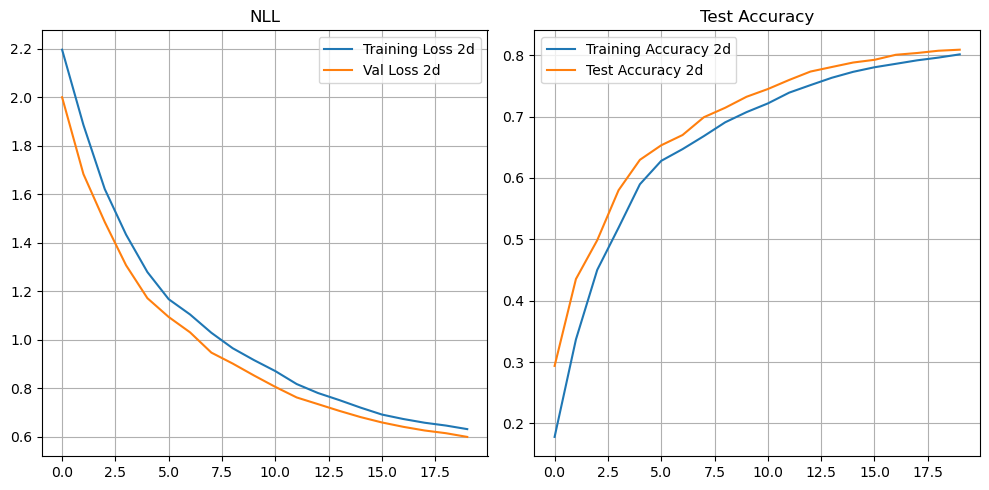

In [6]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot on the first subplot
axs[0].plot(loss_list, label='Training Loss 2d')
axs[0].plot(val_loss_list, label='Val Loss 2d')
axs[0].set_title('NLL')
axs[0].grid(True)
axs[0].legend()

# Plot on the second subplot
axs[1].plot(train_accuracy, label='Training Accuracy 2d')
axs[1].plot(val_accuracy, label='Test Accuracy 2d')
axs[1].set_title('Test Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

# Display the plot
plt.show()

### Parallel Implementation

We can set `vectorize = True` in the `optimizer_step_plane_Nd` to run with multiple tangent vectors in one call

In [7]:
import timeit
device = "cpu"

hmodel = DenseModel(layers = [784,100,10])
tmodel = DenseModel_Torch(layers=[784,100,10])

# map torch weights to fomoh model weights:
hmodel.nn_module_to_htorch_model(tmodel)
hmodel.to(device)

number_hyperplane_directions = 10
lr = 0.8

fun = lambda vectorized: train_step(train_loader, hmodel, loss_module, number_hyperplane_directions, 
                                    lr, vectorized=vectorized)


Weights transferred to htorch model.


In [8]:
%%timeit
# One iteration through the training loader sequential
fun(False)

14.9 s ± 456 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
# One iteration through the training loader vectorized
fun(True)

8.92 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


* Depending on the device, we tend to see (sometimes significant!) speed-up with vectorized = True.